## Preparing data from Lisa dataset

This notebook generates xml files and a pickle data file for a single class from Lisa dataset.
Prepare directories/files at:
```
lisa/
    img/
        imgpool/
                img1.jpg
                img2.jpg
                ...
        useimg/(blank file)
        
    xml/(blank file)
    
    annotations.csv
    
    lisadata_preparation.ipynb (this file)
```

Download Lisa image and place them under `lisa/img/imgpool/`.  
Please have all image files in jpeg format, because that is the only tested file format.
execute:  
`cd img/ && mogrify -format jpg *.png && rm *.png && cd ..`

annotations.csv should have the following structure, derived from the original Lisa dataset CSV format:
```
Filename;Annotation tag;Upper left corner X;Upper left corner Y;Lower right corner X;Lower right corner Y;Occluded,On another road;Origin file;Origin frame number;Origin track;Origin track frame number
```

In [1]:
## Import necessary modules ##

import pickle
import os
import subprocess
import pandas as pd
import numpy as np
from PIL import Image
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET

    
## set constants ##

jpegimagepath = 'img/imgpool/'
xmlfile_destination = 'xml/'
csv_name = 'annotations.csv'
annotation_name = 'stop' # name of the annotation you want to train on

In [2]:
## parse information from csv data ##

df1 = pd.read_csv(csv_name)
df1 = df1[df1['Annotation tag'] == annotation_name]

df1 = df1.drop(['Unnamed: 0',
              'Occluded,On another road',
              'Origin file',
              'Origin frame number',
              'Origin track frame number',
              'Origin track'],
             axis=1)

df1 = df1.rename(index=str,
               columns={'Filename': 'filename',
                        'Annotation tag': 'object',
                        'Upper left corner X': 'xmin',
                        'Upper left corner Y': 'ymin',
                        'Lower right corner X': 'xmax',
                        'Lower right corner Y': 'ymax'})

df1 = df1.replace({'png': 'jpg'}, regex=True)


## parse information from image data ##

# move df1 images to img/useimg/
subprocess.call(['rm img/useimg/*'], shell=True)
for i in range(len(df1)):
    f = df1['filename'][i]
    c = 'cp ' + jpegimagepath + f + ' img/useimg/'
    subprocess.call([c], shell=True)

# gather img information into df2
imgfile_names = os.listdir('img/useimg/')
annotation_list = []
imagesize_list = []

for name in imgfile_names:
    im = Image.open(jpegimagepath + name)
    t = list(im.size)
    t.insert(0,name)
    imagesize_list.append(t)
    
df2 = pd.DataFrame(imagesize_list).rename(index=str, columns={0: 'filename',
                                                              1: 'width',
                                                              2: 'height'})


## concatenate two dataframes together ##
df = pd.merge(df1, df2)
df['coord'] = df[['xmin','ymin','xmax','ymax']].values.tolist()
df = df.groupby(['filename','object','height','width'])['coord'].apply(list)
df = pd.DataFrame(df).reset_index()
df['d'] = df.apply(lambda row: {row['object']:row['coord']}, axis=1)
df = df.groupby(['filename','height','width'])['d'].apply(list)

df[:5]

filename                                height  width
signalAhead_1324866992.avi_image0.jpg   480     640      [{'stop': [[420, 247, 429, 259]]}]
signalAhead_1324866992.avi_image1.jpg   480     640      [{'stop': [[424, 246, 433, 259]]}]
signalAhead_1324866992.avi_image10.jpg  480     640      [{'stop': [[475, 224, 488, 245]]}]
signalAhead_1324866992.avi_image11.jpg  480     640      [{'stop': [[487, 223, 500, 244]]}]
signalAhead_1324866992.avi_image12.jpg  480     640      [{'stop': [[503, 218, 517, 242]]}]
Name: d, dtype: object

In [3]:
## generate XML files ##
subprocess.call(['rm xml/*'], shell=True)
x = 0
for row in df:
    annotation = ET.Element('annotation')
    filename = ET.Element('filename')
    size = ET.Element('size')
    height = ET.SubElement(size, 'height')
    width = ET.SubElement(size, 'width')
    depth = ET.SubElement(size, 'depth')
    
    filename.text = df.index[x][0]
    height.text = str(df.index[x][1])
    width.text = str(df.index[x][2])
    annotation.extend((filename, size))
    
    for i in range(len(df[x][0][annotation_name])):
        obj = ET.SubElement(annotation, 'object')
        bndbox = ET.SubElement(obj, 'bndbox')
        name = ET.SubElement(obj, 'name')
        xmin = ET.SubElement(bndbox, 'xmin')
        ymin = ET.SubElement(bndbox, 'ymin')
        xmax = ET.SubElement(bndbox, 'xmax')
        ymax = ET.SubElement(bndbox, 'ymax')
        
        name.text = annotation_name
        xmin.text = str(df[x][0][name.text][i][0])
        ymin.text = str(df[x][0][name.text][i][1])
        xmax.text = str(df[x][0][name.text][i][2])
        ymax.text = str(df[x][0][name.text][i][3])
        
    tree = ET.ElementTree(annotation)
    ET.dump(tree)
    tree.write(xmlfile_destination + '.'.join(filename.text.split('.')[:-1]) + '.xml')
    x+=1

<annotation><filename>signalAhead_1324866992.avi_image0.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>420</xmin><ymin>247</ymin><xmax>429</xmax><ymax>259</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>signalAhead_1324866992.avi_image1.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>424</xmin><ymin>246</ymin><xmax>433</xmax><ymax>259</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>signalAhead_1324866992.avi_image10.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>475</xmin><ymin>224</ymin><xmax>488</xmax><ymax>245</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>signalAhead_1324866992.avi_image11.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>487</xmin><ymin>223</ymin><xmax>500</xmax><ymax>244</ymax></bndbox><n

<annotation><filename>stop_1323804359.avi_image25.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>33</xmin><ymin>13</ymin><xmax>81</xmax><ymax>58</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323804359.avi_image26.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>15</xmin><ymin>6</ymin><xmax>66</xmax><ymax>53</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323804393.avi_image16.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>356</xmin><ymin>78</ymin><xmax>376</xmax><ymax>96</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>654</xmin><ymin>71</ymin><xmax>676</xmax><ymax>92</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323804393.avi_image17.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox

<annotation><filename>stop_1323804473.avi_image7.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>436</xmin><ymin>39</ymin><xmax>463</xmax><ymax>65</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>24</xmin><ymin>48</ymin><xmax>46</xmax><ymax>71</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323804473.avi_image8.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>444</xmin><ymin>36</ymin><xmax>471</xmax><ymax>62</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>8</xmin><ymin>46</ymin><xmax>30</xmax><ymax>69</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323804473.avi_image9.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>448</xmin><ymin>32</ymin><xmax>478</xmax><ymax>59</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_13

<annotation><filename>stop_1323812778.avi_image17.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>560</xmin><ymin>184</ymin><xmax>593</xmax><ymax>216</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323812778.avi_image18.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>584</xmin><ymin>177</ymin><xmax>621</xmax><ymax>212</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323812778.avi_image19.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>608</xmin><ymin>166</ymin><xmax>650</xmax><ymax>204</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323812778.avi_image20.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>637</xmin><ymin>155</ymin><xmax>681</xmax><ymax>197</ymax></bndbox><name>stop</name></object></

<annotation><filename>stop_1323816448.avi_image19.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>295</xmin><ymin>286</ymin><xmax>330</xmax><ymax>317</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323816448.avi_image2.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>152</xmin><ymin>300</ymin><xmax>171</xmax><ymax>319</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323816448.avi_image20.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>322</xmin><ymin>280</ymin><xmax>358</xmax><ymax>312</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323816448.avi_image21.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>348</xmin><ymin>275</ymin><xmax>386</xmax><ymax>309</ymax></bndbox><name>stop</name></object></a

<annotation><filename>stop_1323816483.avi_image7.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>390</xmin><ymin>318</ymin><xmax>401</xmax><ymax>328</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323816483.avi_image8.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>388</xmin><ymin>317</ymin><xmax>400</xmax><ymax>328</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323816483.avi_image9.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>389</xmin><ymin>327</ymin><xmax>401</xmax><ymax>338</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323817816.avi_image10.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>409</xmin><ymin>265</ymin><xmax>440</xmax><ymax>294</ymax></bndbox><name>stop</name></object></ann

<annotation><filename>stop_1323817842.avi_image3.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>473</xmin><ymin>292</ymin><xmax>489</xmax><ymax>307</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323817842.avi_image4.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>469</xmin><ymin>297</ymin><xmax>486</xmax><ymax>314</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323817842.avi_image5.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>466</xmin><ymin>295</ymin><xmax>483</xmax><ymax>312</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323817842.avi_image6.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>462</xmin><ymin>292</ymin><xmax>481</xmax><ymax>310</ymax></bndbox><name>stop</name></object></anno

<annotation><filename>stop_1323820452.avi_image11.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>493</xmin><ymin>236</ymin><xmax>524</xmax><ymax>266</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>12</xmin><ymin>263</ymin><xmax>43</xmax><ymax>292</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323820452.avi_image12.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>509</xmin><ymin>231</ymin><xmax>542</xmax><ymax>263</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>15</xmin><ymin>260</ymin><xmax>47</xmax><ymax>291</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323820452.avi_image13.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>525</xmin><ymin>229</ymin><xmax>560</xmax><ymax>261</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>17</xmi

<annotation><filename>stop_1323820633.avi_image9.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>510</xmin><ymin>293</ymin><xmax>530</xmax><ymax>312</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323820702.avi_image10.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>525</xmin><ymin>246</ymin><xmax>569</xmax><ymax>288</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323820702.avi_image11.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>559</xmin><ymin>239</ymin><xmax>607</xmax><ymax>286</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323820702.avi_image12.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>593</xmin><ymin>228</ymin><xmax>645</xmax><ymax>278</ymax></bndbox><name>stop</name></object></a

<annotation><filename>stop_1323820809.avi_image7.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>472</xmin><ymin>288</ymin><xmax>500</xmax><ymax>314</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323820809.avi_image8.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>474</xmin><ymin>290</ymin><xmax>503</xmax><ymax>317</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323820809.avi_image9.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>480</xmin><ymin>282</ymin><xmax>510</xmax><ymax>309</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323821086.avi_image0.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>110</xmin><ymin>304</ymin><xmax>135</xmax><ymax>328</ymax></bndbox><name>stop</name></object></anno

<annotation><filename>stop_1323821155.avi_image0.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>392</xmin><ymin>318</ymin><xmax>403</xmax><ymax>328</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323821155.avi_image1.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>397</xmin><ymin>319</ymin><xmax>408</xmax><ymax>329</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323821155.avi_image10.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>404</xmin><ymin>299</ymin><xmax>420</xmax><ymax>315</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323821155.avi_image11.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>406</xmin><ymin>301</ymin><xmax>422</xmax><ymax>317</ymax></bndbox><name>stop</name></object></an

<annotation><filename>stop_1323822602.avi_image10.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>438</xmin><ymin>275</ymin><xmax>462</xmax><ymax>297</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323822602.avi_image11.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>443</xmin><ymin>274</ymin><xmax>468</xmax><ymax>298</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323822602.avi_image12.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>449</xmin><ymin>271</ymin><xmax>474</xmax><ymax>295</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323822602.avi_image13.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>454</xmin><ymin>268</ymin><xmax>480</xmax><ymax>294</ymax></bndbox><name>stop</name></object></

<annotation><filename>stop_1323822794.avi_image10.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>626</xmin><ymin>100</ymin><xmax>697</xmax><ymax>162</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323822794.avi_image2.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>216</xmin><ymin>166</ymin><xmax>254</xmax><ymax>204</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323822794.avi_image3.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>259</xmin><ymin>154</ymin><xmax>302</xmax><ymax>194</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323822794.avi_image4.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>306</xmin><ymin>146</ymin><xmax>350</xmax><ymax>188</ymax></bndbox><name>stop</name></object></ann

<annotation><filename>stop_1323822904.avi_image3.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>313</xmin><ymin>243</ymin><xmax>333</xmax><ymax>262</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323823007.avi_image1.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>506</xmin><ymin>204</ymin><xmax>523</xmax><ymax>222</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323823007.avi_image10.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>520</xmin><ymin>190</ymin><xmax>547</xmax><ymax>216</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323823007.avi_image11.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>522</xmin><ymin>187</ymin><xmax>549</xmax><ymax>215</ymax></bndbox><name>stop</name></object></an

<annotation><filename>stop_1323824762.avi_image0.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>425</xmin><ymin>164</ymin><xmax>448</xmax><ymax>185</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323824762.avi_image1.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>431</xmin><ymin>163</ymin><xmax>455</xmax><ymax>187</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323824762.avi_image10.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>504</xmin><ymin>111</ymin><xmax>553</xmax><ymax>157</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323824762.avi_image11.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>518</xmin><ymin>102</ymin><xmax>572</xmax><ymax>151</ymax></bndbox><name>stop</name></object></an

<annotation><filename>stop_1323896588.avi_image16.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>353</xmin><ymin>263</ymin><xmax>365</xmax><ymax>277</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323896588.avi_image17.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>351</xmin><ymin>262</ymin><xmax>364</xmax><ymax>276</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323896588.avi_image18.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>357</xmin><ymin>271</ymin><xmax>370</xmax><ymax>285</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323896588.avi_image19.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>359</xmin><ymin>260</ymin><xmax>373</xmax><ymax>275</ymax></bndbox><name>stop</name></object></

<annotation><filename>stop_1323896809.avi_image24.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>483</xmin><ymin>155</ymin><xmax>538</xmax><ymax>209</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323896809.avi_image25.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>486</xmin><ymin>119</ymin><xmax>551</xmax><ymax>181</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323896809.avi_image26.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>488</xmin><ymin>97</ymin><xmax>563</xmax><ymax>169</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323896809.avi_image27.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>515</xmin><ymin>63</ymin><xmax>606</xmax><ymax>150</ymax></bndbox><name>stop</name></object></an

<annotation><filename>stop_1323896859.avi_image5.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>147</xmin><ymin>230</ymin><xmax>160</xmax><ymax>244</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>370</xmin><ymin>239</ymin><xmax>383</xmax><ymax>253</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323896859.avi_image6.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>153</xmin><ymin>212</ymin><xmax>167</xmax><ymax>227</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>381</xmin><ymin>236</ymin><xmax>394</xmax><ymax>250</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323896859.avi_image7.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>175</xmin><ymin>220</ymin><xmax>188</xmax><ymax>234</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>409</x

<annotation><filename>stop_1323896946.avi_image17.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>407</xmin><ymin>186</ymin><xmax>427</xmax><ymax>210</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323896946.avi_image18.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>415</xmin><ymin>185</ymin><xmax>436</xmax><ymax>210</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323896946.avi_image19.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>434</xmin><ymin>184</ymin><xmax>456</xmax><ymax>210</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1323896946.avi_image2.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>387</xmin><ymin>232</ymin><xmax>398</xmax><ymax>244</ymax></bndbox><name>stop</name></object></a

<annotation><filename>stop_1324866406.avi_image6.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>429</xmin><ymin>214</ymin><xmax>452</xmax><ymax>238</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1324866406.avi_image7.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>446</xmin><ymin>207</ymin><xmax>471</xmax><ymax>233</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1324866406.avi_image8.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>463</xmin><ymin>202</ymin><xmax>489</xmax><ymax>230</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1324866406.avi_image9.jpg</filename><size><height>480</height><width>640</width><depth /></size><object><bndbox><xmin>482</xmin><ymin>197</ymin><xmax>510</xmax><ymax>227</ymax></bndbox><name>stop</name></object></anno

<annotation><filename>stop_1330545935.avi_image0.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>376</xmin><ymin>138</ymin><xmax>413</xmax><ymax>175</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>709</xmin><ymin>203</ymin><xmax>726</xmax><ymax>227</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1330545935.avi_image1.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>412</xmin><ymin>145</ymin><xmax>451</xmax><ymax>185</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>759</xmin><ymin>215</ymin><xmax>776</xmax><ymax>241</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1330545935.avi_image10.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>903</xmin><ymin>81</ymin><xmax>976</xmax><ymax>155</ymax></bndbox><name>stop</name></object></annotation>
<annotation

<annotation><filename>stop_1330546190.avi_image10.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>786</xmin><ymin>222</ymin><xmax>808</xmax><ymax>246</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>366</xmin><ymin>222</ymin><xmax>389</xmax><ymax>245</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1330546190.avi_image11.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>796</xmin><ymin>219</ymin><xmax>818</xmax><ymax>243</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>362</xmin><ymin>219</ymin><xmax>385</xmax><ymax>242</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1330546190.avi_image12.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>805</xmin><ymin>228</ymin><xmax>829</xmax><ymax>254</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>

<annotation><filename>stop_1331866061.avi_image16.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>657</xmin><ymin>156</ymin><xmax>687</xmax><ymax>187</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>101</xmin><ymin>157</ymin><xmax>131</xmax><ymax>188</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1331866061.avi_image17.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>667</xmin><ymin>150</ymin><xmax>698</xmax><ymax>184</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>79</xmin><ymin>153</ymin><xmax>111</xmax><ymax>186</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1331866061.avi_image18.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>678</xmin><ymin>147</ymin><xmax>710</xmax><ymax>182</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>5

<annotation><filename>stop_1331866288.avi_image23.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>775</xmin><ymin>132</ymin><xmax>823</xmax><ymax>180</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1331866288.avi_image24.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>797</xmin><ymin>128</ymin><xmax>847</xmax><ymax>179</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1331866288.avi_image25.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>820</xmin><ymin>118</ymin><xmax>873</xmax><ymax>173</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1331866288.avi_image26.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>844</xmin><ymin>102</ymin><xmax>902</xmax><ymax>160</ymax></bndbox><name>stop</name></objec

<annotation><filename>stop_1331867195.avi_image17.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>766</xmin><ymin>138</ymin><xmax>792</xmax><ymax>180</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1331867195.avi_image18.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>782</xmin><ymin>140</ymin><xmax>808</xmax><ymax>182</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1331867195.avi_image19.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>796</xmin><ymin>142</ymin><xmax>823</xmax><ymax>184</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1331867195.avi_image2.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>452</xmin><ymin>159</ymin><xmax>477</xmax><ymax>186</ymax></bndbox><name>stop</name></object

<annotation><filename>stop_1333388384.avi_image11.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>537</xmin><ymin>153</ymin><xmax>572</xmax><ymax>188</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388384.avi_image12.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>554</xmin><ymin>151</ymin><xmax>589</xmax><ymax>186</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388384.avi_image13.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>570</xmin><ymin>148</ymin><xmax>605</xmax><ymax>183</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388384.avi_image14.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>583</xmin><ymin>146</ymin><xmax>619</xmax><ymax>183</ymax></bndbox><name>stop</name></objec

<annotation><filename>stop_1333388449.avi_image12.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>632</xmin><ymin>158</ymin><xmax>657</xmax><ymax>184</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388449.avi_image13.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>638</xmin><ymin>158</ymin><xmax>665</xmax><ymax>185</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388449.avi_image14.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>643</xmin><ymin>155</ymin><xmax>671</xmax><ymax>183</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388449.avi_image15.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>648</xmin><ymin>151</ymin><xmax>677</xmax><ymax>181</ymax></bndbox><name>stop</name></objec

<annotation><filename>stop_1333388712.avi_image10.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>381</xmin><ymin>187</ymin><xmax>405</xmax><ymax>212</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388712.avi_image11.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>422</xmin><ymin>183</ymin><xmax>446</xmax><ymax>207</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388712.avi_image12.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>464</xmin><ymin>180</ymin><xmax>488</xmax><ymax>205</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388712.avi_image13.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>508</xmin><ymin>176</ymin><xmax>532</xmax><ymax>202</ymax></bndbox><name>stop</name></objec

<annotation><filename>stop_1333388746.avi_image5.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>655</xmin><ymin>147</ymin><xmax>681</xmax><ymax>173</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388746.avi_image6.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>662</xmin><ymin>147</ymin><xmax>689</xmax><ymax>174</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388746.avi_image7.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>670</xmin><ymin>142</ymin><xmax>698</xmax><ymax>170</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333388746.avi_image8.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>678</xmin><ymin>136</ymin><xmax>708</xmax><ymax>166</ymax></bndbox><name>stop</name></object></

<annotation><filename>stop_1333392917.avi_image0.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>757</xmin><ymin>133</ymin><xmax>793</xmax><ymax>169</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333392917.avi_image1.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>795</xmin><ymin>129</ymin><xmax>835</xmax><ymax>170</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333392917.avi_image2.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>838</xmin><ymin>127</ymin><xmax>881</xmax><ymax>170</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333392917.avi_image3.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>886</xmin><ymin>121</ymin><xmax>930</xmax><ymax>166</ymax></bndbox><name>stop</name></object></

<annotation><filename>stop_1333394846.avi_image9.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>655</xmin><ymin>162</ymin><xmax>680</xmax><ymax>189</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333396743.avi_image0.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>641</xmin><ymin>188</ymin><xmax>661</xmax><ymax>207</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333396743.avi_image1.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>649</xmin><ymin>191</ymin><xmax>669</xmax><ymax>210</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333396743.avi_image10.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>673</xmin><ymin>171</ymin><xmax>700</xmax><ymax>198</ymax></bndbox><name>stop</name></object><

<annotation><filename>stop_1333397461.avi_image23.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>848</xmin><ymin>95</ymin><xmax>902</xmax><ymax>151</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333397461.avi_image24.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>897</xmin><ymin>76</ymin><xmax>958</xmax><ymax>136</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333397461.avi_image3.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>213</xmin><ymin>160</ymin><xmax>234</xmax><ymax>182</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>517</xmin><ymin>164</ymin><xmax>534</xmax><ymax>183</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333397461.avi_image4.jpg</filename><size><height>522</height><width>1024</width><depth /></size><o

<annotation><filename>stop_1333397469.avi_image9.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>397</xmin><ymin>223</ymin><xmax>412</xmax><ymax>239</ymax></bndbox><name>stop</name></object><object><bndbox><xmin>186</xmin><ymin>245</ymin><xmax>200</xmax><ymax>258</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333397574.avi_image0.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>669</xmin><ymin>199</ymin><xmax>686</xmax><ymax>216</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333397574.avi_image1.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>674</xmin><ymin>196</ymin><xmax>692</xmax><ymax>214</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333397574.avi_image10.jpg</filename><size><height>522</height><width>1024</width><depth /></size><

<annotation><filename>stop_1333397736.avi_image13.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>894</xmin><ymin>139</ymin><xmax>947</xmax><ymax>191</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333397736.avi_image14.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>926</xmin><ymin>129</ymin><xmax>983</xmax><ymax>186</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333397736.avi_image2.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>718</xmin><ymin>172</ymin><xmax>746</xmax><ymax>201</ymax></bndbox><name>stop</name></object></annotation>
<annotation><filename>stop_1333397736.avi_image3.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>725</xmin><ymin>177</ymin><xmax>755</xmax><ymax>207</ymax></bndbox><name>stop</name></object>

In [4]:
## extract data from xml and create pickle data ##

class XML_preprocessor(object):

    def __init__(self, data_path):
        self.path_prefix = data_path
        self.num_classes = 1
        self.data = dict()
        self._preprocess_XML()

    def _preprocess_XML(self):
        filenames = os.listdir(self.path_prefix)
        for filename in filenames:
            tree = ET.parse(self.path_prefix + filename)
            root = tree.getroot()
            bounding_boxes = []
            one_hot_classes = []
            size_tree = root.find('size')
            width = float(size_tree.find('width').text)
            height = float(size_tree.find('height').text)
            for object_tree in root.findall('object'):
                for bounding_box in object_tree.iter('bndbox'):
                    xmin = float(bounding_box.find('xmin').text)/width
                    ymin = float(bounding_box.find('ymin').text)/height
                    xmax = float(bounding_box.find('xmax').text)/width
                    ymax = float(bounding_box.find('ymax').text)/height
                bounding_box = [xmin,ymin,xmax,ymax]
                bounding_boxes.append(bounding_box)
                class_name = object_tree.find('name').text
                one_hot_class = self._to_one_hot(class_name)
                one_hot_classes.append(one_hot_class)
            image_name = root.find('filename').text
            bounding_boxes = np.asarray(bounding_boxes)
            one_hot_classes = np.asarray(one_hot_classes)
            image_data = np.hstack((bounding_boxes, one_hot_classes))
            self.data[image_name] = image_data
    
    def _to_one_hot(self,name):
        one_hot_vector = [0] * self.num_classes
        if name == annotation_name:
            one_hot_vector[0] = 1
            """
        elif name == 'bicycle':
            one_hot_vector[1] = 1
        elif name == 'bird':
            one_hot_vector[2] = 1
        elif name == 'boat':
            one_hot_vector[3] = 1
        elif name == 'bottle':
            one_hot_vector[4] = 1
        elif name == 'bus':
            one_hot_vector[5] = 1
        elif name == 'car':
            one_hot_vector[6] = 1
        elif name == 'cat':
            one_hot_vector[7] = 1
        elif name == 'chair':
            one_hot_vector[8] = 1
        elif name == 'cow':
            one_hot_vector[9] = 1
        elif name == 'diningtable':
            one_hot_vector[10] = 1
        elif name == 'dog':
            one_hot_vector[11] = 1
        elif name == 'horse':
            one_hot_vector[12] = 1
        elif name == 'motorbike':
            one_hot_vector[13] = 1
        elif name == 'person':
            one_hot_vector[14] = 1
        elif name == 'pottedplant':
            one_hot_vector[15] = 1
        elif name == 'sheep':
            one_hot_vector[16] = 1
        elif name == 'sofa':
            one_hot_vector[17] = 1
        elif name == 'train':
            one_hot_vector[18] = 1
        elif name == 'tvmonitor':
            one_hot_vector[19] = 1
            """
        else:
            print('unknown label: %s' %name)
        return one_hot_vector
    
data = XML_preprocessor(xmlfile_destination).data
pickle.dump(data,open('data.p','wb'))

## check if the image and the annotation is right
This step is optional. Everytime this step is executed, it automatically picks random picture and show it with an annotation bounding box.

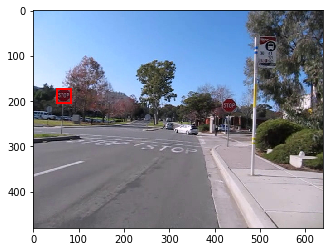

In [5]:
## import necessary modules ##
import cv2
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline


## pick random picture and show ##
rand = randint(0,len(df.index))
file = df[[rand]].index[0][0]
PATH = jpegimagepath + file
image = cv2.imread(PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image/255.)
currentAxis = plt.gca()


## add bounding box ##
# TODO: make multiple bounding boxes
xmin_p, ymin_p, xmax_p, ymax_p = df.loc[pd.IndexSlice[file]][0][0][annotation_name][0]

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
color = colors[0]
coords = (xmin_p, ymin_p), xmax_p-xmin_p+1, ymax_p-ymin_p+1

currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))

plt.show()